# Análisis de clasificación de las tasas de suicidio

En este trabajo se procedera a la clasificación y predicción de los grupos con alto riesgo de suicidio, por lo tanto, este análisis tiene como objetivo investigar si varias características como la edad, el sexo, la población, etc. tienen poder de clasificación para identificar grupos de alto riesgo, esto es importante para poder prevenir suicidios y crear planes de contingencia conociendo a que grupos intervenir más.

Este es un análisis didáctico llevado a cabo en el taller de análisis de datos de la USFQ, por Cristhian Ortiz 
Se Usara el conjunto de datos "Resumen de tasas de suicidios de 1985 a 2016" de Kaggle 

In [47]:
#Cargar las librerias necesarias:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [48]:
#Importamos la data.
data = pd.read_csv("Suicidios.csv")

#Exploramos el numero de columnas.
data.columns
data.head()


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers


In [49]:
#Cambiar nombre a las columnas
data.columns = ["country", "year", "sex", "age", "suicides_no", "population", "suicides_per_100k_pop", "country-year", "HDI_for_year", "gdp_for_year", "gdp_per_capita", "generation"]
data.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers


#### Análisis exploratorio

In [50]:
#Crearemos una nueva varible dummy (risk) 

#Si la tasa de suicidios por 100k hab > al promedio de suicidios por 100k, seran de alto riesgo,
#caso contrario son de bajo riesgo.

mean = data["suicides_per_100k_pop"].mean()
data['risk'] = (data["suicides_per_100k_pop"] >= mean) * 1
data.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation,risk
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X,0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers,0


In [51]:
mean

12.816097411933894

In [52]:
#Vemos si existen valores perdidos
data.isnull().sum()

country                      0
year                         0
sex                          0
age                          0
suicides_no                  0
population                   0
suicides_per_100k_pop        0
country-year                 0
HDI_for_year             19456
gdp_for_year                 0
gdp_per_capita               0
generation                   0
risk                         0
dtype: int64

#### Limpiando la data

In [53]:
# Información sobre los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                27820 non-null  object 
 1   year                   27820 non-null  int64  
 2   sex                    27820 non-null  object 
 3   age                    27820 non-null  object 
 4   suicides_no            27820 non-null  int64  
 5   population             27820 non-null  int64  
 6   suicides_per_100k_pop  27820 non-null  float64
 7   country-year           27820 non-null  object 
 8   HDI_for_year           8364 non-null   float64
 9   gdp_for_year           27820 non-null  object 
 10  gdp_per_capita         27820 non-null  int64  
 11  generation             27820 non-null  object 
 12  risk                   27820 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(6)
memory usage: 2.7+ MB


In [54]:
# Eliminamos comas de la columna "gdp_for_year"
data['gdp_for_year'] = data['gdp_for_year'].str.replace(',', '')

# Eliminamos HDI_for_year debido a muchos valores nulos (NAN)
data = data.drop(["HDI_for_year"], axis = 1)


In [55]:
#Vemos si existen valores perdidos
data.isnull().any()

country                  False
year                     False
sex                      False
age                      False
suicides_no              False
population               False
suicides_per_100k_pop    False
country-year             False
gdp_for_year             False
gdp_per_capita           False
generation               False
risk                     False
dtype: bool

In [56]:
#Volvemos a revisar que nuestras variables sean el tipo de dato necesario para el analisis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                27820 non-null  object 
 1   year                   27820 non-null  int64  
 2   sex                    27820 non-null  object 
 3   age                    27820 non-null  object 
 4   suicides_no            27820 non-null  int64  
 5   population             27820 non-null  int64  
 6   suicides_per_100k_pop  27820 non-null  float64
 7   country-year           27820 non-null  object 
 8   gdp_for_year           27820 non-null  object 
 9   gdp_per_capita         27820 non-null  int64  
 10  generation             27820 non-null  object 
 11  risk                   27820 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 2.4+ MB


In [57]:
# Cambianos el tipo de dato del PIB
data["gdp_for_year"] = data["gdp_for_year"].astype(float)

In [58]:
# Trabajaremoscon 2 decimales places
pd.options.display.float_format = "{:.2f}".format
data.describe()

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,risk
count,27820.00,27820.00,27820.00,27820.00,27820.00,27820.00,27820.00
mean,2001.26,242.57,1844793.62,12.82,445580969025.73,16866.46,0.31
std,8.47,902.05,3911779.44,18.96,1453609985940.92,18887.58,0.46
min,1985.00,0.00,278.00,0.00,46919625.00,251.00,0.00
25%,1995.00,3.00,97498.50,0.92,8985352832.00,3447.00,0.00
50%,2002.00,25.00,430150.00,5.99,48114688201.00,9372.00,0.00
75%,2008.00,131.00,1486143.25,16.62,260202429150.00,24874.00,1.00
max,2016.00,22338.00,43805214.00,224.97,18120714000000.00,126352.00,1.00


In [59]:
# Numero de Valores unico 
data.nunique()

country                    101
year                        32
sex                          2
age                          6
suicides_no               2084
population               25564
suicides_per_100k_pop     5298
country-year              2321
gdp_for_year              2321
gdp_per_capita            2233
generation                   6
risk                         2
dtype: int64

In [60]:
# Valores unicos para las columnas de interes
cols = data[["country", "year", "sex", "age", "generation", "risk"]]

for column in list(cols):
    print(f"\033[1m  {column} unique values: \033[0m")
    print("")
    print(data[column].unique())
    print("")

  country unique values: 

['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Cabo Verde'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominica' 'Ecuador' 'El Salvador' 'Estonia'
 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Kazakhstan' 'Kiribati' 'Kuwait' 'Kyrgyzstan' 'Latvia'
 'Lithuania' 'Luxembourg' 'Macau' 'Maldives' 'Malta' 'Mauritius' 'Mexico'
 'Mongolia' 'Montenegro' 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway'
 'Oman' 'Panama' 'Paraguay' 'Philippines' 'Poland' 'Portugal'
 'Puerto Rico' 'Qatar' 'Republic of Korea' 'Romania' 'Russian Federation'
 'Saint Kitts and Nevis' 'Saint Lucia' 'Saint Vincent and Grenadines'
 'San Marino' 'Serbia' 'Seychelles' 'Singapore' 'Sl

#### Matriz de Correlacion y mapa de Calor

In [61]:
# MAtriz de correlacion para variables continuas
continuous = data.drop(["risk"], axis = 1)
corr = continuous.corr()
corr

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita
year,1.00,-0.00,0.01,-0.04,0.09,0.34
suicides_no,-0.00,1.00,0.62,0.31,0.43,0.06
population,0.01,0.62,1.00,0.01,0.71,0.08
suicides_per_100k_pop,-0.04,0.31,0.01,1.00,0.03,0.00
gdp_for_year,0.09,0.43,0.71,0.03,1.00,0.30
gdp_per_capita,0.34,0.06,0.08,0.00,0.30,1.00


Text(0.06, -0.16, 'Fig. 1. Mapa de Calor Correlacion')

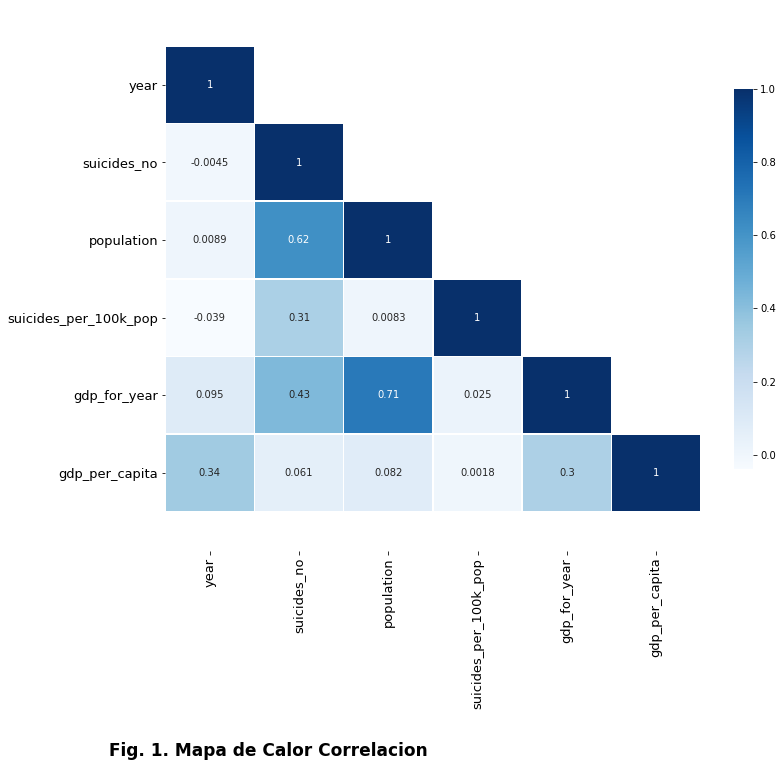

In [62]:
#Mapa de calor para variables continuas

# Triangulo inferior
corr_lower = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize = (12,10))

ax = sns.heatmap(corr_lower, cmap = "Blues",annot = True, 
                 linewidths = 0.5, cbar_kws={"shrink": .7})

ax.tick_params(axis = "both", labelsize = 13)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.text(0.06,-0.16,"Fig. 1. Mapa de Calor Correlacion", fontsize = 17, fontweight = "bold")


#### Total de suicidios por año

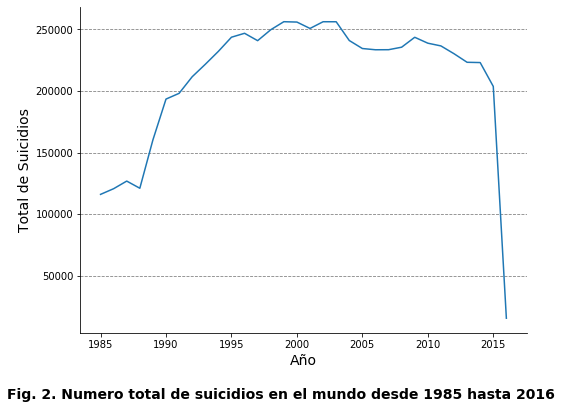

In [63]:
yearly_data = data.groupby("year").sum()

# Graficar
yearly_data.reset_index(level = 0, inplace = True)
plt.rcParams["figure.figsize"] = [8, 6]
yearly_suicide_graph = yearly_data.plot(kind = "line", x = "year", y = "suicides_no")

# Nombres a los Ejes
yearly_suicide_graph.set_xlabel("Año", size = 14)
yearly_suicide_graph.set_ylabel("Total de Suicidios", size = 14)
yearly_suicide_graph.set_title("Fig. 2. Numero total de suicidios en el mundo desde 1985 hasta 2016"
                               , x = 0.45, y = -0.22, 
                               size = 14, fontweight = "bold")

# Mejores visuales
yearly_suicide_graph.spines["right"].set_visible(False)
yearly_suicide_graph.spines["top"].set_visible(False)
yearly_suicide_graph.get_legend().remove()

# Lineas entrecortadas horizontales
yearly_suicide_graph.set_axisbelow(True)
yearly_suicide_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Total de Suicidios por Año y por Genero 

In [64]:
# Analizamos si el numero de Hombres y mujeres es balanceado

print("Numero de hombres y Mujeres:")
count1 = data['sex'].value_counts()
count1

Numero de hombres y Mujeres:


female    13910
male      13910
Name: sex, dtype: int64

Vemos que el número de hombres y mujeres es igual, esta balanceado

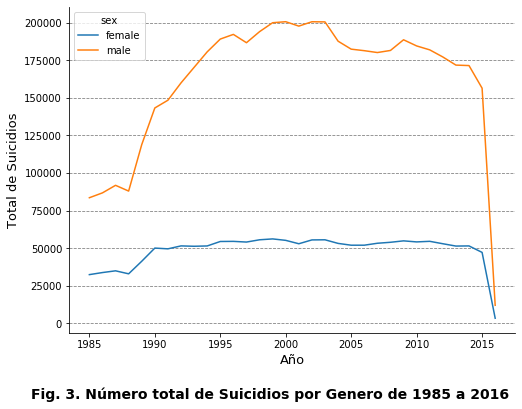

In [65]:
gender_data = data.groupby(["year", "sex"]).sum()
gender_table = gender_data.pivot_table(index = "year", columns = "sex", 
                        values = "suicides_no", aggfunc = "sum")
# Graficar
plt.rcParams["figure.figsize"] = [8, 6]
gender_graph = gender_table.plot()

gender_graph.spines["right"].set_visible(False)
gender_graph.spines["top"].set_visible(False)

plt.xlabel("Año", size = 13)
plt.ylabel("Total de Suicidios", size = 13)
plt.title("Fig. 3. Número total de Suicidios por Genero de 1985 a 2016", 
          x = 0.45, y = -0.22,
          size = 14, fontweight = "bold")

gender_graph.set_axisbelow(True)
gender_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Total de Suicidios por grupo de edad

In [66]:
# Verificamos si las observaciones estan balanceadas

print("Número de observaciones por grupo de edad: ")
count = data['age'].value_counts()
count

Número de observaciones por grupo de edad: 


75+ years      4642
15-24 years    4642
25-34 years    4642
55-74 years    4642
35-54 years    4642
5-14 years     4610
Name: age, dtype: int64

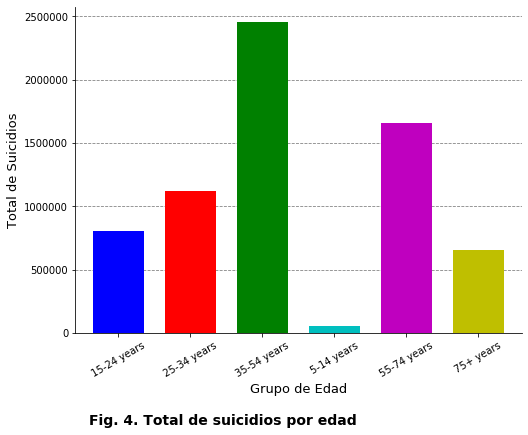

In [67]:
age_table = data.pivot_table('suicides_no', index='age', aggfunc='sum')
age_table.reset_index(level = 0, inplace = True)

# Graficando
# Colors of the bars de las barras
colors = ["b", "r", "g", "c", "m", "y"]
age_graph = age_table.plot(x = "age", y = "suicides_no", kind = "bar", 
                           width = 0.7, color = colors)

plt.xlabel("Grupo de Edad", size = 13)
plt.ylabel("Total de Suicidios", size = 13)
plt.title("Fig. 4. Total de suicidios por edad", 
          x = 0.33, y = -0.3,
          size = 14, fontweight = "bold")
plt.xticks(rotation = 30)

age_graph.spines["right"].set_visible(False)
age_graph.spines["top"].set_visible(False)

# Removing the legend
age_graph.get_legend().remove()

age_graph.set_axisbelow(True)
age_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Total de Suicidios por año y grupo de edad

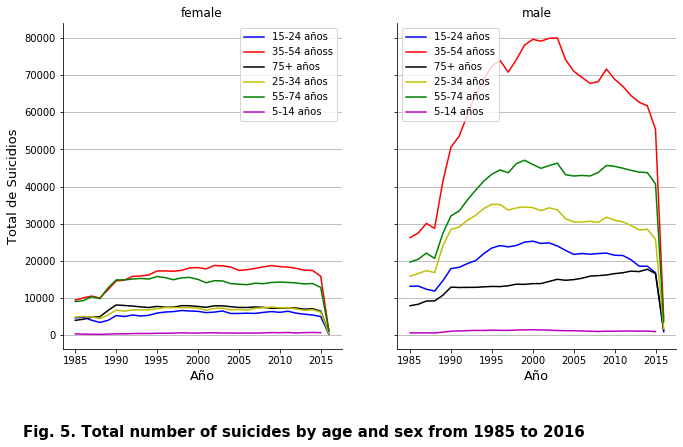

In [68]:
gender_age_data = data.groupby(["year", "sex", "age"]).suicides_no.sum().reset_index()

# Grafica
def plot(df, sex, age, ax, color):
    _df = df.query("(sex == @sex) & (age == @age)")
    _df.plot(
        kind = "line", x = "year", y = "suicides_no", ax = ax, color = color
)
    return ax
fig, ax = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

# Naming the legends
labels = ["15-24 años", "35-54 añoss", "75+ años", "25-34 años", "55-74 años", "5-14 años"]

for (i, sex) in enumerate(gender_age_data.sex.unique()):
    plot(gender_age_data, sex,"15-24 years", ax[i], "b")
    plot(gender_age_data, sex,"35-54 years", ax[i], "r")
    plot(gender_age_data, sex,"75+ years", ax[i], "k")
    plot(gender_age_data, sex,"25-34 years", ax[i], "y")
    plot(gender_age_data, sex,"55-74 years", ax[i], "g")
    plot(gender_age_data, sex,"5-14 years", ax[i], "m")
    ax[i].set_title(str(sex))
    ax[i].legend(labels = labels)
    

for (i, _ax) in enumerate(ax):
    
    # setting axis labels
    _ax.set_xlabel("Año", size = 13)
    _ax.set_ylabel("Total de Suicidios", size = 13)
    
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    
    _ax.yaxis.grid(True)
    

plt.suptitle("Fig. 5. Total number of suicides by age and sex from 1985 to 2016", x = 0.43, 
             y = -0.05, fontsize=15, fontweight = "bold")
plt.show()

#### Tasa de suicidios por años y paises

In [ ]:

country_year_data = data.groupby(['country', 'year'], sort = True).sum()

country_year_data_suicides = country_year_data[["suicides_per_100k_pop"]].reset_index()
country_year_data_suicides.columns = ["country", "year", "Suicides per 100k Population"]

# Plotting
country_year_graph = sns.FacetGrid(country_year_data_suicides, col = "country", col_wrap = 4, sharey = True)
country_year_graph.map(plt.plot, "year", "Suicides per 100k Population", marker = ".")
plt.show()

In [35]:

country_data = data.groupby("country").sum()
country_data_suicides = country_data[["suicides_per_100k_pop"]].reset_index()
country_data_suicides = country_data_suicides.sort_values("suicides_per_100k_pop", ascending = False)
country_data_suicides.head()

,country,suicides_per_100k_pop
75,Russian Federation,11305.13
52,Lithuania,10588.88
40,Hungary,10156.07
47,Kazakhstan,9519.52
73,Republic of Korea,9350.45


#### PIB per Capita y tasa de Suicidios

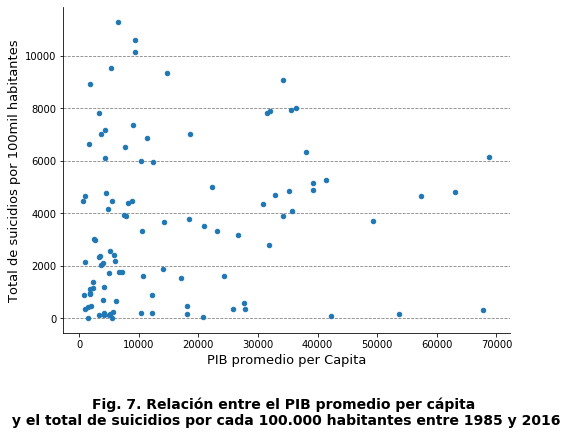

In [38]:
avg_gdp_data = data.groupby("country").agg({"suicides_no": "sum",
                                  "suicides_per_100k_pop": "sum",         
                                  "gdp_per_capita": "mean",
                                  "gdp_for_year": "mean"}).reset_index()

# Plotting
plt.rcParams["figure.figsize"] = [8, 6]
avg_gdp_graph = avg_gdp_data.plot(x = "gdp_per_capita", y = "suicides_per_100k_pop", kind = "scatter")

avg_gdp_graph.set_xlabel("PIB promedio per Capita", size = 13)
avg_gdp_graph.set_ylabel("Total de suicidios por 100mil habitantes", size = 13)
avg_gdp_graph.set_title("Fig. 5. Relación entre el PIB promedio per cápita \n y el total de suicidios por cada 100.000 habitantes entre 1985 y 2016 ", 
                        size = 14,
                        x = 0.5, y = -0.3,
                        fontweight = "bold")

avg_gdp_graph.spines["right"].set_visible(False)
avg_gdp_graph.spines["top"].set_visible(False)

avg_gdp_graph.set_axisbelow(True)
avg_gdp_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Relación entre el PIB promedio per cápita \n y el total de suicidios por cada 100.000 habitantes entre 1985 y 2016

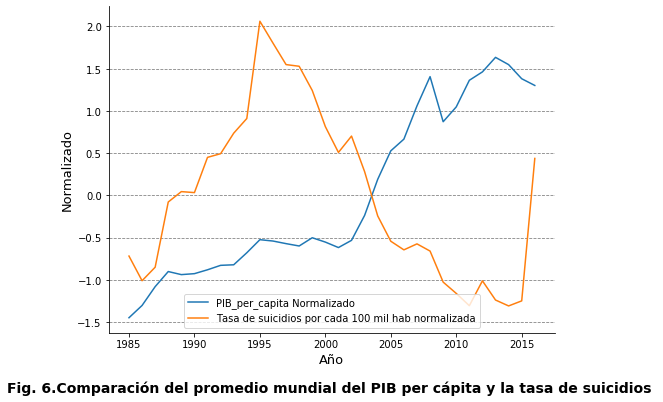

In [40]:

gdp_suicides_data= data.pivot_table(["suicides_per_100k_pop", "gdp_per_capita"],
                      index = "year", aggfunc = "mean")

# Normalizacion
normalized = (gdp_suicides_data - gdp_suicides_data.mean())/ gdp_suicides_data.std()
normalized.columns = ["PIB_per_capita Normalizado", "Tasa de suicidios por cada 100 mil hab normalizada"]

# Grafico
plt.rcParams["figure.figsize"] = [8, 6]
ax = normalized.plot()

ax.set_xlabel("Año", size = 13)
ax.set_ylabel("Normalizado", size = 13)
ax.set_title("Fig. 6.Comparación del promedio mundial del PIB per cápita y la tasa de suicidios ", 
                        size = 14,
                        x = 0.5, y = -0.2,
                        fontweight = "bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color = "gray", linestyle = "dashed")

#### Numero de observaciones en cada clase

In [41]:
print("Numero de observaciones en cada clase:")
count = data['risk'].value_counts()
count

Numero de observaciones en cada clase:


0    19061
1     8759
Name: risk, dtype: int64

In [42]:
# Vemos que la data no esta balanceada

majority = data[data.risk == 0]
minority = data[data.risk == 1]

upsampled = resample(minority, replace=True,     
                                n_samples=19061, 
                                random_state=123)

df= pd.concat([majority, upsampled])

print("Numero de observaciones en cada clase despues del balanceo:")
df.risk.value_counts()

Numero de observaciones en cada clase despues del balanceo:


1    19061
0    19061
Name: risk, dtype: int64

In [43]:
# Preparando la data para la clasificacion 

# Conviertiendo variables categoricas a numericas
le = LabelEncoder()
df["country"] = le.fit_transform(df["country"])

df["sex"] = le.fit_transform(df["sex"])

df.generation.replace(["G.I. Generation", "Silent", "Boomers", "Generation X", "Millenials", "Generation Z"],
                     ["0", "1", "2", "3", "4", "5"], inplace = True)

# Cambiando el tipo de dato a generacion

df["generation"] = df["generation"].astype(int)

# Reemplazando el grupo de edad por sus promedios
df.age.replace(["5-14 years", "15-24 years", "25-34 years", 
                "35-54 years", "55-74 years", "75+ years"],
              [np.array([5,14]).mean(), np.array([15,24]).mean(), np.array([25,34]).mean(), 
               np.array([35,54]).mean(), np.array([55,74]).mean(), np.array([75]).mean()],
               inplace = True
              )

#### Clasificacion

In [45]:
# Separando la varaible objetivo y sus predictoras

X = df.drop(["risk", "country-year", "suicides_per_100k_pop"], axis = 1)
y = df["risk"]

# Escalando X
scaled_X = (X-X.mean())/ X.std()

# Conjunto de entrenamiento  y testeo
X_train, X_test, y_train, y_test = model_selection.train_test_split(scaled_X, y, test_size=0.25, random_state = 40)

# Numero de filas y columnas
print("Numero de observaciones y columnas")
print("Conjunto de entrenamiento:")
print(X_train.shape)
print(y_train.shape)
print("Conjunto de Testeo:")
print(X_test.shape)
print(y_test.shape)

Numero de observaciones y columnas
Conjunto de entrenamiento:
(28591, 9)
(28591,)
Conjunto de Testeo:
(9531, 9)
(9531,)


#### Logistic Regression

In [46]:
logistic_model = linear_model.LogisticRegression(solver = "lbfgs")
logistic_model.fit(X_train, y_train)

lr_pred = logistic_model.predict(X_test)

# Entrenando y testeando la exactitud

lr_train_acc = logistic_model.score(X_train, y_train)
lr_test_acc = logistic_model.score(X_test, y_test)

print("\033[1m Logistic regression precision : \033[0m")
print(f" Precision de Entrenamiento: {lr_train_acc}")
print(f"Presicion de Testeo: {lr_test_acc}")
print("")

lm_con_mat = metrics.confusion_matrix(y_test, lr_pred)
print("\033[1m Matriz Confusion para el logistic regression: \033[0m")
print(lm_con_mat)
print("")

lr_report = metrics.classification_report(y_test, lr_pred)
print("\033[1m Reporte Logistic regression : \033[0m")
print(lr_report)

 Logistic regression precision : 
 Precision de Entrenamiento: 0.9124899443880942
Presicion de Testeo: 0.9173224215717134

 Matriz Confusion para el logistic regression: 
[[4376  369]
 [ 419 4367]]

 Reporte Logistic regression : 
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4745
           1       0.92      0.91      0.92      4786

    accuracy                           0.92      9531
   macro avg       0.92      0.92      0.92      9531
weighted avg       0.92      0.92      0.92      9531

